# Setup

In [161]:
from scipy.io import loadmat
import control as ctrl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


# Importar Dataset

In [162]:
# Carregar o arquivo .mat
data = loadmat('Dataset_Grupo2.mat')

# Acessar os conjuntos de dados relevantes
data_degrau = data['TARGET_DATA____ProjetoC213_Degrau']
data_saida = data['TARGET_DATA____ProjetoC213_Saida']

# Converter os dados em DataFrames do Pandas
df_degrau = pd.DataFrame(data_degrau)
df_saida = pd.DataFrame(data_saida)

# Transpor os DataFrames para que as colunas correspondam aos passos do tempo
df_degrau = df_degrau.transpose()
df_saida = df_saida.transpose()

# Alterar os nomes das colunas no DataFrame transposto
df_degrau.columns = ['Tempo', 'Degrau']
df_saida.columns = ['Tempo', 'Saída']

df = df_degrau

df['Saída'] = df_saida['Saída']

In [163]:
df.head()

,Tempo,Degrau,Saída
0,0.0,2.0,0.0
1,0.1,2.0,0.0
2,0.2,2.0,0.0
3,0.3,2.0,0.0
4,0.4,2.0,0.0


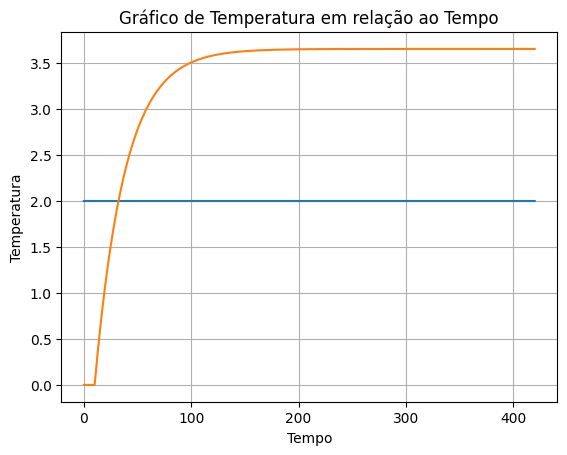

In [164]:
plt.plot(df['Tempo'], df['Degrau'])
plt.plot(df['Tempo'], df['Saída'])
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.title('Gráfico de Temperatura em relação ao Tempo')
plt.grid(True)
plt.show()

# Ganho Estatico

In [165]:
# Calculate static gain
valorFinal = df['Saída'].iloc[-1]
amplitudeDegrau =  df['Degrau'].iloc[-1]
k = valorFinal / amplitudeDegrau
print(f"  - O Ganho Estático do Sistema é k = {k:.4f}.\n\n")

  - O Ganho Estático do Sistema é k = 1.8268.




# Atraso de Transporte

In [166]:
# Calculate transport delay and time constant
atrasoTransporte = 0
for i, temp in enumerate(df['Saída']):
    if temp != 0 and atrasoTransporte == 0:
        atrasoTransporte = df['Tempo'].iloc[i - 1]
        print(f"O Atraso de Transporte do Sistema é T = {atrasoTransporte:.2f}.")


O Atraso de Transporte do Sistema é T = 10.00.


In [167]:
for tau in range(1, 6):
  print(f'Amplitude no instante {tau if tau > 1 else " "}τ = {(1 - np.exp(-tau)):.4f}')

Amplitude no instante  τ = 0.6321
Amplitude no instante 2τ = 0.8647
Amplitude no instante 3τ = 0.9502
Amplitude no instante 4τ = 0.9817
Amplitude no instante 5τ = 0.9933


In [168]:
constanteTempo = 0
for i, temp in enumerate(df['Saída']):
        if temp >= (0.6321 * valorFinal):
            constanteTempo = df['Tempo'].iloc[i] - atrasoTransporte
            print(f"A Constante de Tempo do Sistema é t = {constanteTempo:.2f}.\n")
            break

A Constante de Tempo do Sistema é t = 28.10.



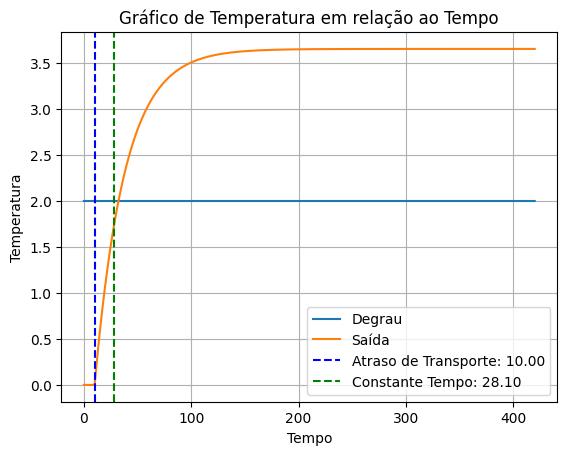

In [169]:
# Your existing code
plt.plot(df['Tempo'], df['Degrau'], label='Degrau')
plt.plot(df['Tempo'], df['Saída'], label='Saída')
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.title('Gráfico de Temperatura em relação ao Tempo')
plt.grid(True)

# Plotting the vertical line at constanteTempo
plt.axvline(x=atrasoTransporte, color='b', linestyle='--', label=f'Atraso de Transporte: {atrasoTransporte:.2f}')

# Plotting the vertical line at constanteTempo
plt.axvline(x=constanteTempo, color='g', linestyle='--', label=f'Constante Tempo: {constanteTempo:.2f}')


# Showing legend
plt.legend()

plt.show()

In [170]:
sys = ([k], [constanteTempo, 1])
tout, yout = signal.step(sys, T=np.linspace(0, df['Tempo'].iloc[-1], len(df['Tempo'].values)))

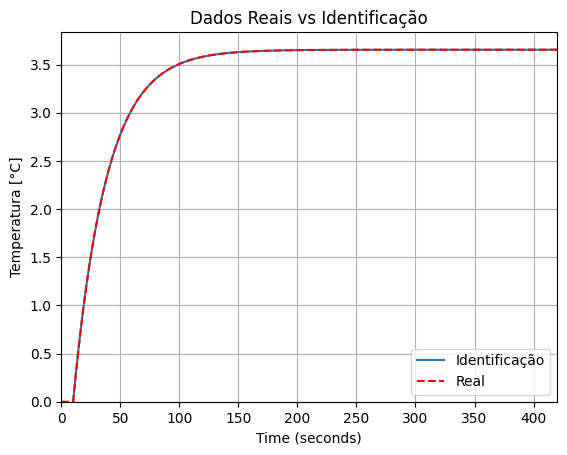

In [171]:
plt.figure()
plt.plot(tout + atrasoTransporte, yout * amplitudeDegrau, label='Identificação')
plt.plot(df['Tempo'], df['Saída'], 'r--', label='Real')

# Definindo label e limites para os eixos:
plt.xlabel('Time (seconds)')
plt.xlim([0, len(df['Tempo'].values) * 0.1])

plt.ylabel('Temperatura [°C]')
plt.ylim([0, max(df['Degrau'].max(), max(yout * amplitudeDegrau)) * 1.05])

# Definindo o título e a posição da legenda do gráfico:
plt.title('Dados Reais vs Identificação')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

O método clássico de controle PID tem suas raízes na década de 1920 e foi desenvolvido inicialmente para controle de processos industriais. Ele se baseia em três termos: proporcional, integral e derivativo, que são ajustados manualmente para alcançar um desempenho adequado.

O método novo PID, por outro lado, é uma evolução que incorpora técnicas mais avançadas de controle, como sintonia automática, controle adaptativo e estratégias de otimização. Ele utiliza algoritmos mais sofisticados para ajustar os parâmetros do controlador de forma dinâmica, levando em consideração as características específicas do sistema em tempo real.

Em resumo, enquanto o método clássico de controle PID é mais tradicional e requer ajustes manuais, o método novo PID é mais avançado e utiliza técnicas automatizadas para otimizar o desempenho do sistema de controle.

# Smith

In [172]:
def Smith(Step, Time, Output):
    if not isinstance(Time, np.ndarray) or not isinstance(Output, np.ndarray):
        raise TypeError('Type Error: The arguments must be arrays.')
    
    if not np.isscalar(Step):
        raise TypeError('TypeError: The argument \'Step\' must be a constant.')
   
    Output = Output - Output[0]
    valorFinal = Output[-1]
    k = valorFinal / Step
    
    t1 = 0
    t2 = 0
    for i in range(len(Output)):
        if Output[i] >= 0.283 * valorFinal and t1 == 0:
            t1 = Time[i]
        
        if Output[i] >= 0.6321 * valorFinal:
            t2 = Time[i]
            break
    
    tau = 1.5 * (t2 - t1)
    Theta = t2 - tau
    identificacaoSmith = [k, tau, Theta]
    
    return identificacaoSmith


In [173]:
[k, tau, Theta] = Smith(df['Degrau'].mean(),df['Tempo'].values,df['Saída'].values)

# Print the identified parameters
print(f"Identified Parameters with Smith:")
print(f"  - Gain (k): {k:.4f}")
print(f"  - Time Delay (θ): {Theta:.4f}")
print(f"  - Time Constant (τ): {tau:.4f}")

Identified Parameters with Smith:
  - Gain (k): 1.8268
  - Time Delay (θ): 10.0500
  - Time Constant (τ): 28.0500


# IMC && CHR sem OverShoot

In [174]:
fine_tune = [0.5, 0.1, 0]

<TransferFunction>: sys[208]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


   1.827
-----------
28.05 s + 1

Identified Parameters IMC:
  - Kp: 1.2050
  - Ti: 4.2616
  - Td: 33.0750
<TransferFunction>: sys[209]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


5.135 s^2 + 1.205 s + 0.03643
-----------------------------
          s^2 + 2 s

Identified Parameters CHR:
  - Kp: 0.9167
  - Ti: 28.0500
  - Td: 5.0250
<TransferFunction>: sys[210]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


4.606 s^2 + 0.9167 s + 0.03268
------------------------------
          s^2 + 2 s



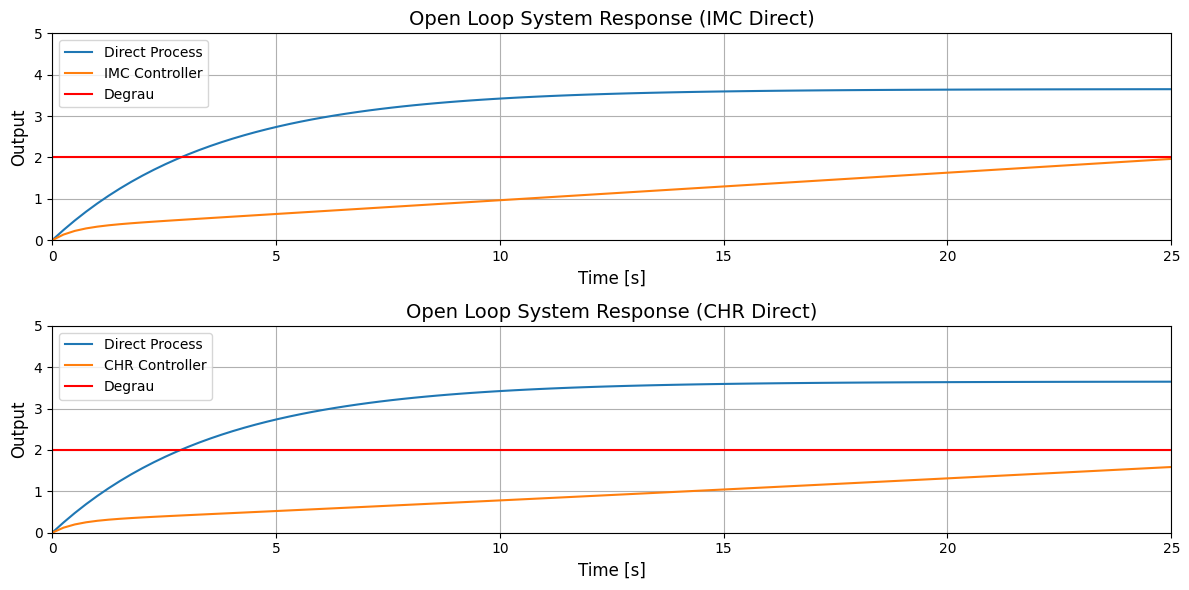

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# Define parameters
constanteTempo = tau
atrasoTransporte = Theta
ganhoEstatico = k
lambda_ = 10
Tempo = df['Tempo'].values
Degrau = df['Degrau'].values
amplitudeDegrau = 2  # Define the step input amplitude

# Direct Process Transfer Function
num_direct = [ganhoEstatico]
den_direct = [constanteTempo, 1]
sys_direct = ctrl.TransferFunction(num_direct, den_direct)

print(sys_direct)

# PID Controller Design for Direct Process (IMC)
Kp_IMC = (2 * constanteTempo + atrasoTransporte) / (ganhoEstatico * (2 * lambda_ + atrasoTransporte))
Td_IMC = constanteTempo * atrasoTransporte / (2 * constanteTempo + atrasoTransporte)
Ti_IMC = constanteTempo + atrasoTransporte / 2
PID_IMC_direct = ctrl.tf([Kp_IMC * Td_IMC, Kp_IMC, Kp_IMC / Ti_IMC], [1,2,0])
# Print the identified parameters
print(f"Identified Parameters IMC:")
print(f"  - Kp: {Kp_IMC:.4f}")
print(f"  - Ti: {Td_IMC:.4f}")
print(f"  - Td: {Ti_IMC:.4f}")

print(PID_IMC_direct)

# PID Controller Design for Direct Process (CHR)
Kp_CHR = 0.6 * constanteTempo / (ganhoEstatico * atrasoTransporte)
Ti_CHR = constanteTempo
Td_CHR = atrasoTransporte / 2
PID_CHR_direct = ctrl.tf([Kp_CHR * Td_CHR, Kp_CHR, Kp_CHR / Ti_CHR], [1,2,0])

# Print the identified parameters
print(f"Identified Parameters CHR:")
print(f"  - Kp: {Kp_CHR:.4f}")
print(f"  - Ti: {Ti_CHR:.4f}")
print(f"  - Td: {Td_CHR:.4f}")

print(PID_CHR_direct)

# Simulate open-loop responses
t, yout_IMC_direct = ctrl.step_response(sys_direct)
t, yout_PID_IMC_direct = ctrl.step_response(sys_direct * PID_IMC_direct)
t, yout_CHR_direct = ctrl.step_response(sys_direct)
t, yout_PID_CHR_direct = ctrl.step_response(sys_direct * PID_CHR_direct)

# Plotting the open-loop system response for the direct process with IMC and CHR controllers
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, yout_IMC_direct * amplitudeDegrau, label='Direct Process')
plt.plot(t, yout_PID_IMC_direct * amplitudeDegrau, label='IMC Controller')
plt.plot(Tempo, Degrau, 'r', label='Degrau')
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Output', fontsize=12)
plt.grid(True)
plt.legend(loc='best', fontsize=10)
plt.title('Open Loop System Response (IMC Direct)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 5)
plt.xlim(0, 25)

plt.subplot(2, 1, 2)
plt.plot(t, yout_CHR_direct * amplitudeDegrau, label='Direct Process')
plt.plot(t, yout_PID_CHR_direct * amplitudeDegrau, label='CHR Controller')
plt.plot(Tempo, Degrau, 'r', label='Degrau')
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Output', fontsize=12)
plt.grid(True)
plt.legend(loc='best', fontsize=10)
plt.title('Open Loop System Response (CHR Direct)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 5)
plt.xlim(0, 25)

plt.tight_layout()
plt.show()


System Transfer Function: <TransferFunction>: sys[223]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


           3.337
---------------------------
28.05 s^2 + 282.9 s + 10.05

FineTune Arraylike: [0.5, 0.1, 0]

Função de Transferência para o Controlador PID IMC:
  - Kp = 1.2050
  - Ti = 33.0750
  - Td = 4.2616
<TransferFunction>: sys[224]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


5.135 s^2 + 1.205 s + 0.03643
-----------------------------
       0.5 s^2 + 0.1 s


Função de Transferência para o Controlador PID CHR sem overshoot:
  - Kp = 0.9167
  - Ti = 28.0500
  - Td = 5.0250
<TransferFunction>: sys[225]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


4.606 s^2 + 0.9167 s + 0.03268
------------------------------
       0.5 s^2 + 0.1 s



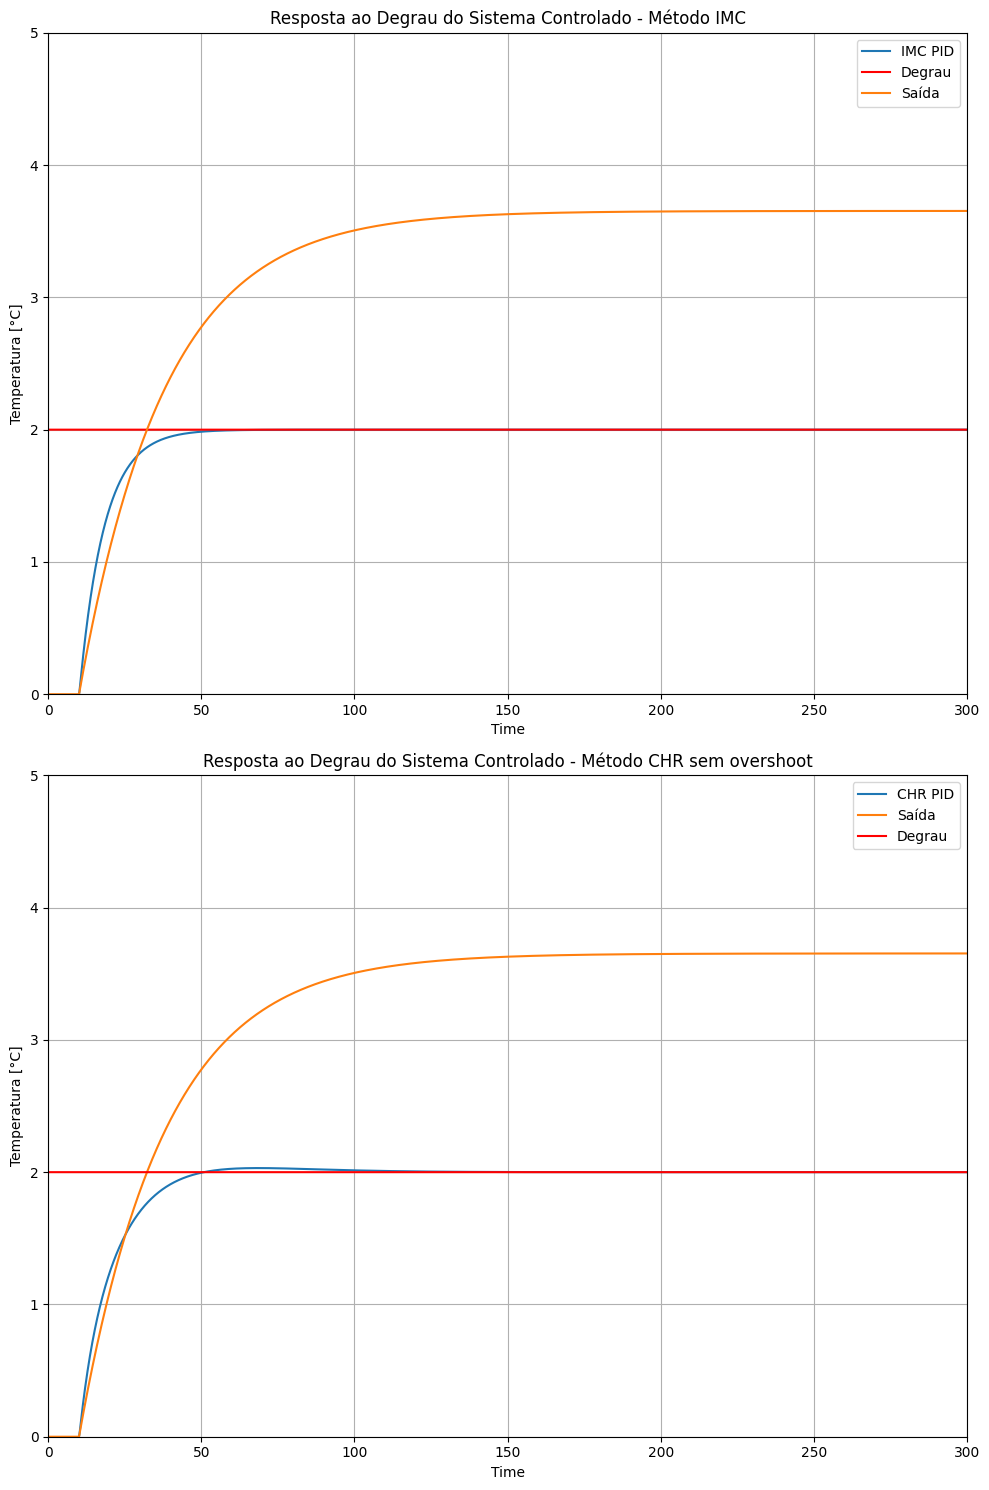

In [176]:
# Given parameters
constanteTempo = tau
atrasoTransporte = Theta
ganhoEstatico = k
lambda_ = 10
Tempo = df['Tempo'].values
Degrau = df['Degrau'].values

# System transfer function (example)
sys = ctrl.tf([ganhoEstatico], [constanteTempo, 1]) * ctrl.tf([ganhoEstatico], [1, atrasoTransporte])
print(f"System Transfer Function: {sys}")
print(f"FineTune Arraylike: {fine_tune}")

# Method 2 - Internal Model Control (IMC) PID
Kp = (2 * constanteTempo + atrasoTransporte) / (ganhoEstatico * (2 * lambda_ + atrasoTransporte))
Td = constanteTempo * atrasoTransporte / (2 * constanteTempo + atrasoTransporte)
Ti = constanteTempo + atrasoTransporte / 2
print('\nFunção de Transferência para o Controlador PID IMC:')
print(f'  - Kp = {Kp:.4f}')
print(f'  - Ti = {Ti:.4f}')
print(f'  - Td = {Td:.4f}')
PID_IMC = ctrl.tf([Kp * Td, Kp, Kp / Ti], fine_tune)
print(PID_IMC)

# Method 3 - CHR without overshoot
Kp = 0.6 * constanteTempo / (ganhoEstatico * atrasoTransporte)
Ti = constanteTempo
Td = atrasoTransporte / 2
print('\nFunção de Transferência para o Controlador PID CHR sem overshoot:')
print(f'  - Kp = {Kp:.4f}')
print(f'  - Ti = {Ti:.4f}')
print(f'  - Td = {Td:.4f}')
PID_CHR = ctrl.tf([Kp * Td, Kp, Kp / Ti], fine_tune)
print(PID_CHR)

# Fechando a malha com realimentação de ganho unitário
sys_closed_IMC = ctrl.feedback(ctrl.series(PID_IMC, sys), 1)
sys_closed_CHR = ctrl.feedback(ctrl.series(PID_CHR, sys), 1)

# Plot step response
plt.figure(figsize=(10, 15))

plt.subplot(2, 1, 1)
t_IMC, yout_IMC = ctrl.step_response(sys_closed_IMC, T=Tempo)
plt.plot(t_IMC + atrasoTransporte, yout_IMC*amplitudeDegrau, label='IMC PID')
plt.plot(Tempo, Degrau, 'r', label='Degrau')
plt.plot(df['Tempo'], df['Saída'], label='Saída')
plt.xlabel('Time')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend(loc='best')
plt.title('Resposta ao Degrau do Sistema Controlado - Método IMC')
plt.ylim(0, 5)
plt.xlim(0, 300)

plt.subplot(2, 1, 2)
t_CHR, yout_CHR = ctrl.step_response(sys_closed_CHR, T=Tempo)
plt.plot(t_CHR + atrasoTransporte, yout_CHR*amplitudeDegrau, label='CHR PID')
plt.plot(df['Tempo'], df['Saída'], label='Saída')
plt.plot(Tempo, Degrau, 'r', label='Degrau')
plt.xlabel('Time')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend(loc='best')
plt.title('Resposta ao Degrau do Sistema Controlado - Método CHR sem overshoot')
plt.ylim(0, 5)
plt.xlim(0, 300)

plt.tight_layout()
plt.show()


# comparacao

erro entre maior valor e setpoint

real

In [177]:
df['Saída'].max() - amplitudeDegrau

1.653598398046983

PID

In [178]:
max(yout_CHR*amplitudeDegrau) - amplitudeDegrau

0.030985516763245347

erro entre ultimo valor e setpoint

real

In [179]:
df['Saída'].iloc[-1] - amplitudeDegrau

1.653598398046983

PID

In [180]:
print(f"{(((yout_CHR*amplitudeDegrau)[-1])- amplitudeDegrau):.2f}")

0.00
